In [157]:
!pip install --upgrade tensorflow




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [158]:
import os
import sys
import pathlib
import click
import yaml
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [185]:
""" trainer.py """
import tensorflow as tf
from tensorflow.keras.utils import Progbar
import tensorflow.keras as K
from model.dataset import Dataset
from model.fp.melspec.melspectrogram import get_melspec_layer
from model.fp.specaug_chain.specaug_chain import get_specaug_chain_layer
from model.fp.nnfp import get_fingerprinter
from model.fp.NTxent_loss_single_gpu import NTxentLoss
from model.fp.online_triplet_loss import OnlineTripletLoss
from model.fp.lamb_optimizer import LAMB
from model.utils.experiment_helper import ExperimentHelper
from model.utils.mini_search_subroutines import mini_search_eval

In [195]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_specaug: spec-augmentation layer.
    m_specaug = get_specaug_chain_layer(cfg, trainable=False)
    #assert(m_specaug.bypass==False) # Detachable by setting m_specaug.bypass.

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_specaug, m_fp

tr_loss = K.metrics.Mean(name='train_loss')

@tf.function
def train_step(X, m_pre, m_specaug, m_fp, loss_obj, opt):
    """ Train step """
    # X: (Xa, Xp)
    # Xa: anchors or originals, s.t. [xa_0, xa_1,...]
    # Xp: augmented replicas, s.t. [xp_0, xp_1] with xp_n = rand_aug(xa_n).
    n_anchors = len(X[0])
    X = tf.concat(X, axis=0)
    feat = m_specaug(m_pre(X))  # (nA+nP, F, T, 1)
    m_fp.trainable = True
    with tf.GradientTape() as t:
        emb = m_fp(feat)  # (BSZ, Dim)
        loss, sim_mtx, _ = loss_obj.compute_loss(emb[:n_anchors, :], emb[n_anchors:, :]) # {emb_org, emb_rep}
    g = t.gradient(loss, m_fp.trainable_variables)

    opt.apply_gradients(zip(g, m_fp.trainable_variables))
    
    avg_loss = tr_loss(loss) # To tensorboard.
    
    return avg_loss, sim_mtx # avg_loss: average within the current epoch


In [188]:
def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg


def update_config(cfg, key1: str, key2: str, val):
    cfg[key1][key2] = val
    return cfg


def print_config(cfg):
    os.system("")
    print('\033[36m' + yaml.dump(cfg, indent=4, width=120, sort_keys=False) +
          '\033[0m')
    return



""" Generate fingerprint (after training) """
def generate(checkpoint_name, checkpoint_index, config, source, output, skip_dummy):
    """ Generate fingerprints from a saved checkpoint.

    ex) python run.py generate CHECKPOINT_NAME

    With custom config: \b\n
        python run.py generate CHECKPOINT_NAME -c CONFIG_NAME

    • If CHECKPOINT_INDEX is not specified, the latest checkpoint in the OUTPUT_ROOT_DIR will be loaded.
    • The default value for the fingerprinting source is [TEST_DUMMY_DB] and [TEST_QUERY_DB] specified in config file.

    """
    from model.utils.config_gpu_memory_lim import allow_gpu_memory_growth
    from model.generate import generate_fingerprint

    cfg = load_config(config)
    allow_gpu_memory_growth()
    generate_fingerprint(cfg, checkpoint_name, checkpoint_index, source, output, skip_dummy)


def evaluate(checkpoint_name, checkpoint_index, config, index_type,
             test_seq_len, test_ids, nogpu):
    """ Search and evalutation.

    ex) python run.py evaluate CHECKPOINT_NAME CHECKPOINT_INDEX

    With options: \b\n

    ex) python run.py evaluate CHECKPOINT_NAME CHEKPOINT_INDEX -i ivfpq -t 3000 --nogpu


    • Currently, the 'evaluate' command does not reference any information other
    than the output log directory from the config file.
    """
    from eval.eval_faiss import eval_faiss

    cfg = load_config(config)
    emb_dir = cfg['DIR']['OUTPUT_ROOT_DIR'] + checkpoint_name + '/' + \
        str(checkpoint_index) + '/'

    if nogpu:
        eval_faiss([emb_dir, "--index_type", index_type, "--test_seq_len",
                    test_seq_len, "--test_ids", test_ids, "--nogpu"])
    else:
        eval_faiss([emb_dir, "--index_type", index_type, "--test_seq_len",
                    test_seq_len, "--test_ids", test_ids])



In [201]:
checkpoint_name:str = "CHECKPOINT"   # string
checkpoint_index:int = None  # int
config:str = "default"       # string 'default'
index_type:str = 'IVFPQ'  # {'L2', 'IVF', 'IVFPQ', " + "'IVFPQ-RR', 'IVFPQ-ONDISK', HNSW'}"
test_seq_len:str =  '11'   # string '1 3 5 9 11 19' segundos 
test_ids:str = "icassp"      # string 'icassp'
nogpu:bool = False         # False or True
max_epoch:int = 5     # int

In [202]:
cfg = load_config(config)
dataset = Dataset(cfg)

cli: Configuration from ./config/default.yaml


In [203]:
m_pre, m_specaug, m_fp = build_fp(cfg)

In [165]:
d = dataset.get_train_ds()

In [166]:
d[0][1].shape

(16, 1, 8000)

In [167]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display


In [168]:
out = d[0][0][0]

In [169]:
out

array([[0.00387573, 0.00756836, 0.00198364, ..., 0.13735962, 0.0980835 ,
        0.13232422]], dtype=float32)

In [170]:
x1 = d[0][1][0]

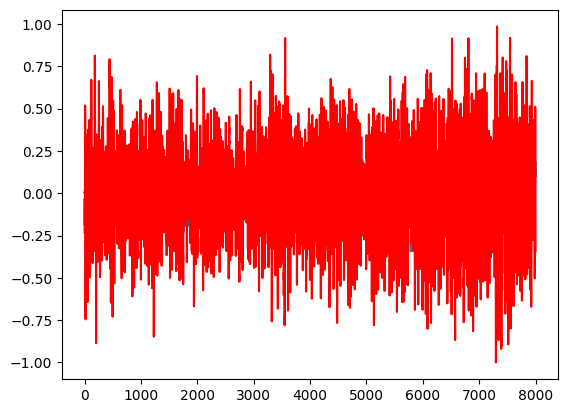

In [171]:

plt.plot(out.squeeze())
plt.plot(x1.squeeze(),'r')
plt.show()

In [172]:
IN = d[0]
n_anchors = len(IN[0])
n_anchors

16

In [173]:
IN = tf.concat(IN, axis=0)

In [174]:
IN.shape

TensorShape([32, 1, 8000])

In [175]:


feat_IN = m_specaug(m_pre(IN))  # (nA+nP, F, T, 1)

In [176]:
feat_IN.shape

TensorShape([32, 256, 32, 1])

In [177]:
mel = feat_IN[0, :, :, 0].numpy()

In [178]:
mel.shape

(256, 32)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

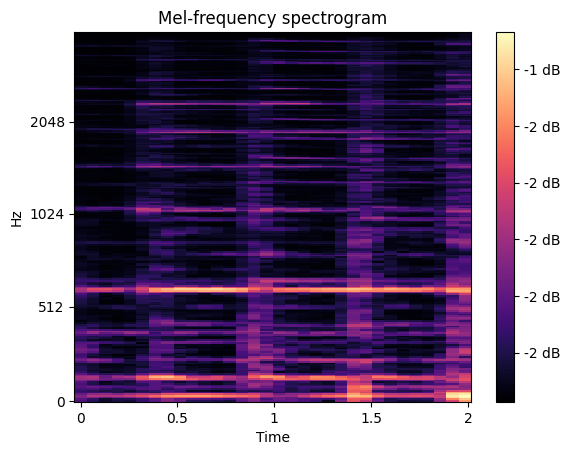

In [179]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(mel, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [180]:
mel2 = feat[16, :, :, 0].numpy()

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

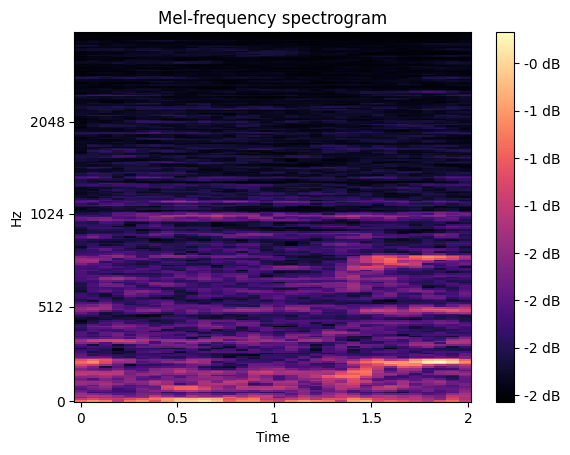

In [181]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(mel2, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [182]:
emb_IN = m_fp(feat_IN)

In [92]:
emb_IN = m_fp(feat_IN)

In [204]:
# Dataloader
dataset = Dataset(cfg)

# Build models.
m_pre, m_specaug, m_fp = build_fp(cfg)

# Learning schedule
total_nsteps = cfg['TRAIN']['MAX_EPOCH'] * len(dataset.get_train_ds())
if cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS':
    lr_schedule = tf.keras.experimental.CosineDecay(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        decay_steps=total_nsteps,
        alpha=1e-06)
elif cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS-RESTART':
    lr_schedule = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        first_decay_steps=int(total_nsteps * 0.1),
        num_periods=0.5,
        alpha=2e-06)
else:
    lr_schedule = float(cfg['TRAIN']['LR'])

# Optimizer
if cfg['TRAIN']['OPTIMIZER'].upper() == 'LAMB':
    opt = LAMB(learning_rate=lr_schedule)
elif cfg['TRAIN']['OPTIMIZER'].upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
else:
    raise NotImplementedError(cfg['TRAIN']['OPTIMIZER'])

# Loss objects
if cfg['LOSS']['LOSS_MODE'].upper() == 'NTXENT': # Default
    loss_obj_train = NTxentLoss(
        n_org=cfg['BSZ']['TR_N_ANCHOR'],
        n_rep=cfg['BSZ']['TR_BATCH_SZ'] - cfg['BSZ']['TR_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
else:
    raise NotImplementedError(cfg['LOSS']['LOSS_MODE'])


In [205]:
ep = 0

# Train
""" Parallelism to speed up preprocessing.............. """
train_ds = dataset.get_train_ds(cfg['DATA_SEL']['REDUCE_ITEMS_P'])

enq = tf.keras.utils.OrderedEnqueuer(
    train_ds, use_multiprocessing=True, shuffle=train_ds.shuffle)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'],
            max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])
i = 0
while i < len(enq.sequence):
    X = next(enq.get()) # X: Tuple(Xa, Xp)
    print(f"mini-batch {i} of {len(enq.sequence)}")

    avg_loss, sim_mtx = train_step(X, m_pre, m_specaug, m_fp, loss_obj_train, opt=opt)

    i += 1
enq.stop()
""" End of Parallelism................................. """






Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dirceusilva/.pyenv/versions/3.9.17/envs/audio/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2339391/2089436535.py", line 14, in <module>
    avg_loss, sim_mtx = train_step(X, m_pre, m_specaug, m_fp, loss_obj_train, opt=opt)
  File "/home/dirceusilva/.pyenv/versions/3.9.17/envs/audio/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filelz8i1044.py", line 19, in tf__train_step
    ag__.converted_call(ag__.ld(opt).apply_gradients, (ag__.converted_call(ag__.ld(zip), (ag__.ld(g), ag__.ld(m_fp).trainable_variables), None, fscope),), None, fscope)
  File "/home/dirceusilva/.pyenv/versions/3.9.17/envs/audio/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradient